# Laboratorio 6 - Parte 1

## Integrantes

- Sergio Orellana 221122
- Rodrigo Mansilla 22611
- Carlos Valladares 221164

# Parte 1 - Teoría

### Pregunta 1
**El ELE se encuentra en $(S^* = N, I^* = 0)$. Describa en términos conceptuales por qué este es un estado de "balance" en el sistema. ¿Qué flujos de entrada y salida se están equilibrando exactamente en el compartimento de susceptibles $(S)$ para que su nivel permanezca constante?**

**Respuesta:**  
En el modelo SIR con demografía (nacimientos y muertes naturales), la ecuación para susceptibles es
$$
\frac{dS}{dt} = \mu N - \beta \frac{S I}{N} - \mu S.
$$
En el ELE tengo $I^*=0$, así que no hay contagios y el término $\beta \frac{S I}{N}$ desaparece. Si además $S^*=N$, el flujo de entrada a $S$ (nacimientos, $\mu N$) se equilibra exactamente con el flujo de salida por muertes naturales ($\mu S = \mu N$). Por eso $\frac{dS}{dt}=0$ y el nivel de susceptibles se mantiene constante es un balance entre nacimientos y muertes en $S$, sin pérdida por infección porque $I=0$.


### Pregunta 2
**El equilibrio endémico representa un estado donde la enfermedad persiste de forma estable. Explique la tensión fundamental que existe en este equilibrio. ¿Qué fuerza impulsa el aumento de infecciones y qué fuerza contraria la frena, permitiendo que el número de infectados $I^*$ se mantenga constante y no sea cero?**

**Respuesta:**  
En el equilibrio endémico $I^*>0$ y la enfermedad persiste. La tensión fundamental es:
- **Fuerza que impulsa el aumento de infecciones:** la incidencia de nuevos contagios $\beta \frac{S I}{N}$, que crece con los contactos efectivos entre $S$ e $I$.
- **Fuerza contraria que frena la propagación:** la salida de infectados por recuperación ($\gamma I$) y muerte natural ($\mu I$).  
En equilibrio, estas fuerzas se compensan,
$$
\beta \frac{S^* I^*}{N} = (\gamma+\mu)\, I^*,
$$
lo que implica
$$
S^* = \frac{N(\gamma+\mu)}{\beta} = \frac{N}{R_0}
$$
cuando $I^*>0$. La enfermedad se “sostiene” porque los nacimientos reponen susceptibles, mientras que recuperaciones y muertes evitan un crecimiento ilimitado de $I$.


### Pregunta 3
**Imagine que quiere construir un Modelo Basado en Agentes (MBA) que represente la misma dinámica de este modelo SIR. ¿Cómo implementaría los procesos de "nacimiento" $(\mu N)$ y "muerte natural" $(\mu S, \mu I, \mu R)$ a nivel de agentes individuales? Describa las reglas o eventos que programaría para los agentes.**

**Respuesta:**  
A nivel de agente, programaría eventos estocásticos por paso de tiempo $\Delta t$:
- **Nacimientos ($\mu N$):** en cada $\Delta t$ genero nuevos agentes susceptibles según una distribución de Poisson con media $\mu \, N(t) \, \Delta t$ (o creo individuos uno a uno con la probabilidad adecuada), manteniendo la población aproximadamente constante en promedio.
- **Muertes naturales ($\mu S, \mu I, \mu R$):** a cada agente, independientemente de su estado (S, I, R), le asigno una probabilidad de muerte $p_\text{muerte}=\mu \Delta t$ por paso. Si “muere”, lo elimino del sistema.
- **Procesos epidemiológicos (para completar SIR):**  
  - **Contagio:** cada susceptible se expone a contactos; con probabilidad $p_\text{inf} \approx \beta \frac{I(t)}{N(t)} \Delta t$ (o mediante una red de contactos explícita) pasa a $I$.  
  - **Recuperación:** cada infectado se recupera con probabilidad $p_\text{rec}=\gamma \Delta t$ y pasa a $R$.  
Así reproduzco, en promedio, los mismos flujos que las EDO pero de forma discreta y aleatoria.


### Pregunta 4
**Si ejecutara su MBA y graficara el número total de susceptibles contra el número total de infectados (un espacio de estados proyectado), ¿esperaría que las trayectorias se vieran idénticas a las del modelo de ecuaciones diferenciales? ¿Por qué sí o por qué no? Mencione al menos un factor clave inherente a los MBA que introduciría diferencias en el gráfico.**

**Respuesta:**  
No exactamente. Aunque el MBA puede aproximar la trayectoria media de las EDO, hay diferencias clave:
- **Estocasticidad:** el MBA introduce fluctuaciones por el tamaño finito de la población y el carácter aleatorio de contactos, contagios, nacimientos y muertes.  
- **Estructura de contactos/heterogeneidad:** si uso redes, movilidad o heterogeneidad individual, la dinámica puede alejarse de la curva “suave” de las EDO.  
En el plano $(S,I)$ espero una banda o nube que oscile alrededor de la trayectoria determinista; en poblaciones pequeñas podría haber extinciones estocásticas ($I\to 0$) que el modelo determinista no predice.





# Parte 1 - Práctica


## Modelo



Se define la función que implementa el sistema de ecuaciones diferenciales:
\begin{align*}
\frac{dS}{dt} &= \mu N - \beta S I - \mu S \\
\frac{dI}{dt} &= \beta S I - \gamma I - \mu I
\end{align*}

donde:
- $S$: número de susceptibles  
- $I$: número de infectados  
- $\beta$: tasa de transmisión  
- $\gamma$: tasa de recuperación  
- $\mu$: tasa de natalidad/mortalidad  
- $N$: población total  

La función devuelve las tasas de cambio
$$\frac{dS}{dt}$$
$$\frac{dI}{dt}$$

que determinan la evolución temporal del brote o de la epidemia dentro de la población.


In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

np.random.seed(42)

def sir_vital(y, t, beta, gamma, mu, N):
    S, I = y
    dSdt = mu * N - beta * S * I - mu * S
    dIdt = beta * S * I - gamma * I - mu * I


    return [dSdt, dIdt]


## Configuración

Se definen los parámetros del modelo con valores que garantizan $R_0 > 1 $:
- $N = 1000$: población total  
- $\beta = 0.5 / N$: tasa de transmisión normalizada  
- $\gamma = 0.1$: tasa de recuperación  
- $\mu = 0.02$: tasa de natalidad/mortalidad 

El intervalo de simulación se establece de 0 a 300 días con 1000 puntos de evaluación.

In [2]:
N = 1000
beta = 0.5 / N
gamma = 0.1
mu = 0.02

t = np.linspace(0, 300, 1000)


## Simulación de Trayectorias


Se simulan dos escenarios:
1. **Inicio de brote leve:** (S₀ = 999, I₀ = 1)  
2. **Epidemia mayor:** (S₀ = 700, I₀ = 300)

Se utiliza la función `odeint` para resolver el sistema de ecuaciones en el tiempo. Los resultados se almacenan en matrices con las trayectorias de $S(t)$ e $I(t)$.

In [3]:
y0_brote = [999, 1]
y0_epidemia = [700, 300]

sol_brote = odeint(sir_vital, y0_brote, t, args=(beta, gamma, mu, N))
sol_epi = odeint(sir_vital, y0_epidemia, t, args=(beta, gamma, mu, N))

S_brote, I_brote = sol_brote[:, 0], sol_brote[:, 1]
S_epi, I_epi = sol_epi[:, 0], sol_epi[:, 1]


## Puntos de Equilibrio

Se calculan los dos puntos de equilibrio del sistema:

- **Equilibrio Libre de Enfermedad (ELE):**  

$$  S^* = N, \quad I^* = 0 $$

- **Equilibrio Endémico (si \( R_0 > 1 \)):**  
$$
  S^* = \frac{\gamma + \mu}{\beta}, \quad 
  I^* = \frac{\mu}{\beta}\left(1 - \frac{\gamma + \mu}{\beta N}\right)
$$

También se calcula el número básico de reproducción  $R_0 = \frac{\beta N}{\gamma + \mu}$ 
indicando si la enfermedad puede establecerse de forma endémica.

In [4]:
R0 = beta * N / (gamma + mu)
S_star_end = (gamma + mu) / beta
I_star_end = mu * (N - S_star_end) / (gamma + mu)

ELE = (N, 0)
END = (S_star_end, I_star_end)

print("R0 =", R0)
print("Equilibrio Libre de Enfermedad (ELE):", ELE)
print("Equilibrio Endémico:", END)


R0 = 4.166666666666666
Equilibrio Libre de Enfermedad (ELE): (1000, 0)
Equilibrio Endémico: (240.0, 126.66666666666667)


## Espacio de Estados

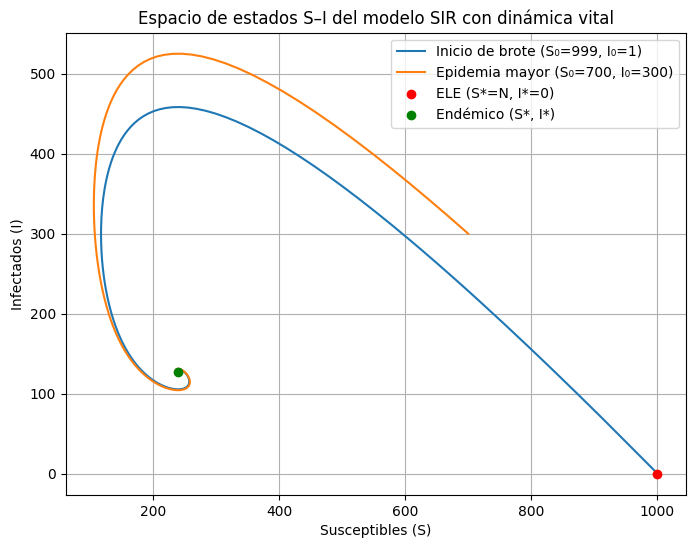

In [5]:
plt.figure(figsize=(8,6))
plt.plot(S_brote, I_brote, label='Inicio de brote (S₀=999, I₀=1)')
plt.plot(S_epi, I_epi, label='Epidemia mayor (S₀=700, I₀=300)')
plt.scatter(*ELE, color='red', label='ELE (S*=N, I*=0)', zorder=5)
plt.scatter(*END, color='green', label='Endémico (S*, I*)', zorder=5)

plt.xlabel("Susceptibles (S)")
plt.ylabel("Infectados (I)")
plt.title("Espacio de estados S–I del modelo SIR con dinámica vital")
plt.legend()
plt.grid(True)
plt.show()


## Análisis

***1) Describa el comportamiento de las dos trayectorias que simuló. ¿Convergen al mismo punto? Si es así, ¿a cuál de los dos equilibrios teóricos corresponde este punto de convergencia?***

Las dos trayectorias  convergen al equilibrio endémico.  Con $R_0>1$, el ELE es inestable y el sistema se asienta en $(S^*, I^*) \approx (240, 126.67)$.


***2) La trayectoria que comienza en I₀=1 muestra un gran arco antes de estabilizarse. ¿Qué representa este arco en términos de la dinámica de una epidemia?***

Es la ola epidémica transitoria. Al inicio, $(S)$ es alto y $(I)$ crece rápido; luego, la depleción de susceptibles y las salidas por recuperación/mortalidad reducen la transmisión, curvando la trayectoria hasta estabilizarse en el equilibrio endémico.


***3) Su R₀ calculado con los parámetros dados fue mayor que 1. ¿Cómo se alinea el resultado visual de su simulación (el destino final de las trayectorias) con lo que R₀ > 1 predice sobre la persistencia de la enfermedad?***

Es coherente, el $R_0$  implica persistencia de la infección. Visualmente, ninguna trayectoria va al ELE $(N,0)$; ambas convergen al equilibrio endémico.


***4) Sin volver a ejecutar el código, ¿qué esperaría que sucediera con las trayectorias si se implementara una campaña de salud pública que redujera β a la mitad, haciendo que R₀ sea menor que 1? ¿Hacia qué punto de equilibrio convergerían ahora las trayectorias y por qué?***

- Con la mitad de $\beta$: $R_0' = R_0/2 \approx 2.08 > 1$ → seguiría habiendo equilibrio endémico con menor $I^*$, pero no desaparece.
- Para lograr $R_0<1$: se requiere $\beta < (\gamma+\mu)/N = 0.00012$, es decir, reducir $\beta$ en más de 76% ≈ dividirla por 4.17.

En ese caso, todas las trayectorias convergerían al **ELE** $(N,0)$ y la enfermedad se extinguiría.

# Referencias

- Best, A. (2023, July 12). The SIR model with demographics. Introducing Mathematical Biology. https://sheffield.pressbooks.pub/introducingmathematicalbiology/chapter/the-sir-model-with-demographics/ 
- GeeksforGeeks. (2022, May 13). Overview of SIR epidemic model for Corona virus outbreak prediction. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/overview-of-sir-epidemic-model-for-corona-virus-outbreak-prediction/ 
- GeeksforGeeks. (2022b, May 13). Overview of SIR epidemic model for Corona virus outbreak prediction. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/overview-of-sir-epidemic-model-for-corona-virus-outbreak-prediction/
- Libretexts. (2022, July 18). 4.3: The SIR Epidemic Disease model. Mathematics LibreTexts. https://math.libretexts.org/Bookshelves/Applied_Mathematics/Mathematical_Biology_(Chasnov)/04%3A_Infectious_Disease_Modeling/4.03%3A_The_SIR_Epidemic_Disease_Model
